Purpose: Develop code for XGBoost regression.<br>
Author: Anna Pardo<br>
Date initiated: Jan. 27, 2026

In [7]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# load X data
data_x = pd.read_csv("./logtpm_means_for_xgboost.txt",sep="\t",header="infer")
data_x.head()

/tmp/ipykernel_326/287417221.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_x = pd.read_csv("./logtpm_means_for_xgboost.txt",sep="\t",header="infer")


,genotype,Yucal.01G000100.v2.1_D_1,Yucal.01G000100.v2.1_D_13,Yucal.01G000100.v2.1_D_17,Yucal.01G000100.v2.1_D_21,Yucal.01G000100.v2.1_D_5,Yucal.01G000100.v2.1_D_9,Yucal.01G000100.v2.1_W_1,Yucal.01G000100.v2.1_W_13,Yucal.01G000100.v2.1_W_17,...,YufilH1095147m.g_D_17,YufilH1095147m.g_D_21,YufilH1095147m.g_D_5,YufilH1095147m.g_D_9,YufilH1095147m.g_W_1,YufilH1095147m.g_W_13,YufilH1095147m.g_W_17,YufilH1095147m.g_W_21,YufilH1095147m.g_W_5,YufilH1095147m.g_W_9
0,12,4.671265,4.921500,5.005791,4.798222,4.095183,4.459452,4.871347,4.712149,4.941031,...,0.424053,0.856323,0.929884,0.173245,0.000000,0.000000,0.240835,0.246639,0.391822,0.328985
1,13,5.144395,4.975804,4.853688,5.012945,4.893604,5.055911,5.258964,5.489978,5.268651,...,0.000000,2.333759,1.608336,1.076163,0.689379,1.505695,2.286190,1.511368,1.536379,0.992734
2,18,5.684827,5.435823,5.405006,5.475807,5.751970,5.898819,5.573681,5.574150,5.244135,...,0.000000,0.000000,0.618082,0.124582,0.224390,0.000000,0.000000,0.000000,0.000000,0.400971
3,19,5.135665,5.190652,5.463501,5.250987,4.594409,5.076206,5.157064,5.322314,5.205319,...,0.000000,0.091623,0.571384,0.044394,0.000000,0.000000,0.373620,0.372175,0.000000,0.081672
4,1AB,5.494941,5.422841,5.219464,4.980347,5.043138,5.326056,5.546432,5.651210,5.358873,...,1.287099,2.131974,1.034189,1.762691,0.000000,0.654828,1.146550,1.117638,0.582830,1.622332


In [20]:
data_x["genotype"] = data_x["genotype"].astype(str)
data_x["genotype"].unique()

array(['12', '13', '18', '19', '1AB', '2AB', '36', '37', '43', '45', '46',
       '48', '51', '56', '6', '61', 'Eudy', 'G'], dtype=object)

In [3]:
# load phys data
phys = pd.read_csv("/home/leviathan22/Yucca_genomics/phys_figures/deltas_treatgt_licorphys.csv",sep=",",header="infer")
phys.head()

,species,genotype,photo_delta_W,photo_se_delta_W,cond_delta_W,cond_se_delta_W,photo_delta_D,photo_se_delta_D,cond_delta_D,cond_se_delta_D,color
0,Yg,18,-3.821684,0.219126,-0.031201,0.002785,-1.624543,0.201811,-0.007143,0.002081,mediumslateblue
1,Yg,48,-2.288366,0.598488,-0.020870,0.005956,0.558297,0.303311,0.007360,0.001799,turquoise
2,Yg,43,-2.897358,0.344567,-0.020584,0.002659,0.512161,0.227245,0.001173,0.000822,orchid
3,Yg,70,-12.929507,0.995204,-0.081691,0.007796,-6.571107,1.837028,-0.020726,0.011786,firebrick
4,Yg,61,-6.862964,1.015016,-0.049251,0.005818,-3.295913,1.119586,-0.012409,0.006775,saddlebrown


In [4]:
phys["species"].unique()

array(['Yg', 'Yf', 'Ya'], dtype=object)

In [5]:
# subset phys to just Yg
ygphys = phys[phys["species"]=="Yg"].drop("species",axis=1)
ygphys.head()

,genotype,photo_delta_W,photo_se_delta_W,cond_delta_W,cond_se_delta_W,photo_delta_D,photo_se_delta_D,cond_delta_D,cond_se_delta_D,color
0,18,-3.821684,0.219126,-0.031201,0.002785,-1.624543,0.201811,-0.007143,0.002081,mediumslateblue
1,48,-2.288366,0.598488,-0.020870,0.005956,0.558297,0.303311,0.007360,0.001799,turquoise
2,43,-2.897358,0.344567,-0.020584,0.002659,0.512161,0.227245,0.001173,0.000822,orchid
3,70,-12.929507,0.995204,-0.081691,0.007796,-6.571107,1.837028,-0.020726,0.011786,firebrick
4,61,-6.862964,1.015016,-0.049251,0.005818,-3.295913,1.119586,-0.012409,0.006775,saddlebrown


In [6]:
# do more column subsetting...don't need SEs or colors, those were just for plotting
ygphys = ygphys[["genotype","photo_delta_W","cond_delta_W","photo_delta_D","cond_delta_D"]]
ygphys.head()

,genotype,photo_delta_W,cond_delta_W,photo_delta_D,cond_delta_D
0,18,-3.821684,-0.031201,-1.624543,-0.007143
1,48,-2.288366,-0.020870,0.558297,0.007360
2,43,-2.897358,-0.020584,0.512161,0.001173
3,70,-12.929507,-0.081691,-6.571107,-0.020726
4,61,-6.862964,-0.049251,-3.295913,-0.012409


In [8]:
# do a little rearranging of columns
a = ygphys[["genotype","photo_delta_W","cond_delta_W"]]
b = ygphys[["genotype","photo_delta_D","cond_delta_D"]]

In [9]:
a["treat"] = "W"
b["treat"] = "D"
a.rename(columns={"photo_delta_W":"photo_delta","cond_delta_W":"cond_delta"},inplace=True)
b.rename(columns={"photo_delta_D":"photo_delta","cond_delta_D":"cond_delta"},inplace=True)

/tmp/ipykernel_326/1628465529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["treat"] = "W"
/tmp/ipykernel_326/1628465529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b["treat"] = "D"
/tmp/ipykernel_326/1628465529.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a.rename(columns={"photo_delta_W":"photo_delt

In [10]:
ygphys_rework = pd.concat([a,b])
ygphys_rework.head()

,genotype,photo_delta,cond_delta,treat
0,18,-3.821684,-0.031201,W
1,48,-2.288366,-0.020870,W
2,43,-2.897358,-0.020584,W
3,70,-12.929507,-0.081691,W
4,61,-6.862964,-0.049251,W


<AxesSubplot: xlabel='treat', ylabel='photo_delta'>

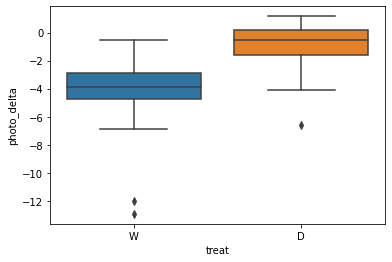

In [12]:
sns.boxplot(data=ygphys_rework,x="treat",y="photo_delta")

<AxesSubplot: xlabel='treat', ylabel='cond_delta'>

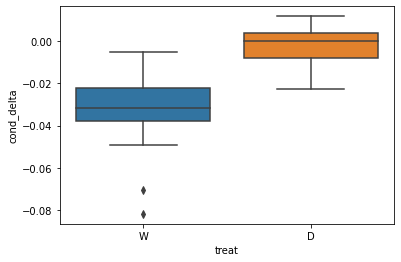

In [13]:
sns.boxplot(data=ygphys_rework,x="treat",y="cond_delta")

In [14]:
data_x.shape

(18, 981829)

In [15]:
ygphys.shape

(22, 5)

In [16]:
# which genotypes are in ygphys but not data_x? are there any that are in data_x but not ygphys (i.e. TPM but no phys)?
set(ygphys["genotype"]).difference(set(data_x["genotype"]))

{'13',
 '15',
 '16',
 '18',
 '19',
 '36',
 '37',
 '43',
 '45',
 '46',
 '48',
 '51',
 '52',
 '53',
 '55',
 '56',
 '61',
 '70'}

In [17]:
set(data_x["genotype"]).difference(set(ygphys["genotype"]))

{6, 12, 13, 18, 19, 36, 37, 43, 45, 46, 48, 51, 56, 61}

In [21]:
ygphys_rework["genotype"] = ygphys_rework["genotype"].astype(str)

In [22]:
bothgt = list(set(data_x["genotype"]).intersection(set(ygphys["genotype"])))

In [23]:
bothgt

['51',
 '13',
 '1AB',
 '19',
 '48',
 '56',
 '18',
 '36',
 '45',
 '43',
 '37',
 'G',
 '61',
 '2AB',
 '46',
 'Eudy']

In [24]:
len(bothgt)

16

In [25]:
set(ygphys_rework["genotype"]).difference(set(data_x["genotype"]))

{'15', '16', '52', '53', '55', '70'}

In [26]:
set(data_x["genotype"]).difference(set(ygphys_rework["genotype"]))

{'12', '6'}

In [27]:
subtpm = data_x[data_x["genotype"].isin(bothgt)]
subphys = ygphys_rework[ygphys_rework["genotype"].isin(bothgt)]

In [29]:
subtpm.shape

(16, 981829)

In [30]:
subphys.shape

(32, 4)

In [31]:
ygphys["genotype"] = ygphys["genotype"].astype(str)
sphys2 = ygphys[ygphys["genotype"].isin(bothgt)]
sphys2.shape

(16, 5)

In [33]:
# save the appropriately subset data
sphys2.to_csv("./subgt_physiology_deltas_for_xgboost.txt",sep="\t",header=True,index=False)

In [34]:
subtpm.to_csv("./subgt_meanTPM_for_xgboost.txt",sep="\t",header=True,index=False)